Implementation of Naive Bayes Algorithm found in the paper Beyond Accuracy: ROI-driven Data Analytics of Empirical Data

In [120]:
import pandas as pd

#Import the data from 2 files (My computer runs out of memory with more)

#alldata = pd.read_csv('./dataset/AllData.csv', low_memory=False)
data_part1 = pd.read_csv('./dataset/Data_part1.csv', low_memory=False) #Only this dataset was used to calculate results, but more can easily be added
#data_part1Stage2 = pd.read_csv('./dataset/Data_part1Stage2.csv', low_memory=False)
#data_part2 = pd.read_csv('./dataset/Data_part2.csv', low_memory=False)
#data_part2Stage2 = pd.read_csv('./dataset/Data_part2Stage2.csv', low_memory=False)
#data_part3 = pd.read_csv('./dataset/Data_part3.csv', low_memory=False)
#data_part3Stage2 = pd.read_csv('./dataset/Data_part3Stage2.csv', low_memory=False)
#data_part4 = pd.read_csv('./dataset/Data_part4.csv', low_memory=False)
#data_part4Stage2 = pd.read_csv('./dataset/Data_part4Stage2.csv', low_memory=False)
#data_part5Stage2 = pd.read_csv('./dataset/Data_part5Stage2.csv', low_memory=False)

In [121]:
dataset_names = [data_part1] #[data_part1, data_part1Stage2] #Add more dataset names to this list to create larger dataset
complete_dataset =  pd.concat(dataset_names, ignore_index=True, sort=False).drop(columns=['Unnamed: 0']) #Put the files into one dataframe
complete_dataset = complete_dataset.drop(columns=list(complete_dataset.filter(regex = '^cf'))) #Remove all columns with cf
complete_dataset = complete_dataset.set_index('id') #Create an explicit index. Each row can now be refered to by it's ID

In [122]:
#Get all of the rows which depend on something
index_dataset = complete_dataset[['depends_on']]
index_dataset = index_dataset.dropna()

#If you have multiple values in one cell, split them into different columns (Ex: 2 items seperated by a comma = 2 columns)
targets = index_dataset['depends_on'].str.split(',', expand=True)
#Count the number of instances in each row
result = targets.apply(pd.Series.value_counts)
#Remove NaN values - they throw things off
result = result.fillna(0)

#Sum all the columns, based on row. This will give us the total count for how many entries 
#are dependent on another, with the index being the ID of the "depends_on" entry
result = result.sum(axis='columns').to_frame()

#Find the entries which have the most references in the "depends_on" column
result = result.sort_values(by = 0, ascending=False)

#Get the top 40 referenced entries
result = result.head(40)

#Make a list of the entries
indicies = result.index.values.tolist()

#Make sure the entries are in string format, with all whitespace stripped
indicies = list(map(str,indicies))
indicies = [i.strip() for i in indicies]
print(indicies)

['1130266', '1448703', '1529362', '1319773', '1231208', '1445197', '1575284', '1574241', '1460343', '1470432', '1471622', '1464426', '1444991', '1218018', '1478118', '1477783', '278458', '1217996', '1344091', '1441308', '1467949', '1353360', '1172897', '1476876', '1480504', '1457891', '910412', '1418995', '1472491', '1477638', '1212797', '1461360', '57805', '231429', '1462470', '1490242', '947490', '1449562', '1464828', '1574159']


In [123]:
#Import the library which has the stopwords (if, the, etc...)
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
nltk.download('stopwords')

#Give me the depends_on and summary column
complete_dataset = complete_dataset[['depends_on', 'summary']]
print(complete_dataset.shape) #Check how big the dataframe is

#Used to remove the stopwords
def removeStopWords(startingList):
    returnedList = [x for x in startingList if x not in stopwords.words('english')]
    return returnedList

#Used to remove punctuation from the summary column
tokenizer = RegexpTokenizer(r'\w+')

#Get the summary column
summary_features = complete_dataset['summary']
summary_features = summary_features.to_frame()
#Remove punctuation
summary_features = summary_features.apply(lambda x: tokenizer.tokenize(x['summary']), axis=1)
#Remove stopwords
summary_features = summary_features.apply(lambda x: removeStopWords(x))

#Get the "depends_on" column into its own dataframe, change each cell to hold a list of strings (each ID = 1 string) instead of one string
targets = complete_dataset['depends_on'].str.split(',').to_frame()
#Replace all NaN values with empty lists
targets['depends_on'] = targets['depends_on'].apply(lambda x: x if isinstance(x, list) else [])
summary_features = summary_features.to_frame()
print(targets)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zachl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(9879, 2)
                                                depends_on
id                                                        
1572867                                                 []
1572870                                                 []
1572872                                                 []
1441804                                          [1455351]
1048589                                                 []
...                                                    ...
1486848                                                 []
1355787                                          [1356874]
1486859                                                 []
1486865  [1482614,  1483099,  1486647,  1547810,  14817...
1486866                                                 []

[9879 rows x 1 columns]


In [124]:
from sklearn.preprocessing import MultiLabelBinarizer

#Change the summary dataframe to onehot encoding - each row can have more than one "1" because sentence have multiple words
mlb = MultiLabelBinarizer()
features = summary_features.join(pd.DataFrame(mlb.fit_transform(summary_features.pop(0)), columns=mlb.classes_, index=summary_features.index))

#Change the depends_on dataframe to onehot encoding
targets = targets.join(pd.DataFrame(mlb.fit_transform(targets.pop('depends_on')), columns=mlb.classes_, index=targets.index))

#Remove whitespaces in the column names
targets.columns = targets.columns.str.strip()
print(targets)

         1000077  1000199  1000317  1000462  1000745  1000775  1000814  \
id                                                                       
1572867        0        0        0        0        0        0        0   
1572870        0        0        0        0        0        0        0   
1572872        0        0        0        0        0        0        0   
1441804        0        0        0        0        0        0        0   
1048589        0        0        0        0        0        0        0   
...          ...      ...      ...      ...      ...      ...      ...   
1486848        0        0        0        0        0        0        0   
1355787        0        0        0        0        0        0        0   
1486859        0        0        0        0        0        0        0   
1486865        0        0        0        0        0        0        0   
1486866        0        0        0        0        0        0        0   

         1000870  1000879  100090  ..

In [125]:
#Select only the  top 40 dependencies
targets = targets[indicies]
#Remove duplicate rows and columns
targets = targets.groupby(level=0, axis=1).sum()
targets = targets.groupby(level=0, axis=0).sum()

#Create a single column of rows that have dependencies in the top 40 and those which do not
targets = targets.max(axis = 1)
print(targets)

id
915        0
2654       0
2678       0
2800       0
2892       0
          ..
1575563    0
1575565    0
1575567    0
1575575    0
1575582    0
Length: 9879, dtype: int32


In [126]:
#Reduce the overall number of entires
#Select all entries that are equal to 1 (has a dependency) and 0 (does not have a dependency)
zeroes = targets[targets == 0]
ones = targets[targets == 1]

#Sample list of zeroes and select 3 times the number of dependency entries
zeroes_sampled = zeroes.sample(n = 3*len(ones))

#combine lists and sort by index
zeroes_ones = pd.concat([zeroes_sampled, ones])
zeroes_ones = zeroes_ones.sort_index(ascending = True)

targets = zeroes_ones

print(zeroes_ones)

id
2800       0
2910       0
5704       0
11459      0
12409      0
          ..
1575419    0
1575442    0
1575448    0
1575557    0
1575560    0
Length: 1028, dtype: int32


In [127]:
#Get the indecies of the selected target values
target_indicies = targets.index.values.tolist()

#Remove duplicate rows
features = features.groupby(level=0, axis=0).sum()
#Select features which match the target indicies
features = features.loc[target_indicies]

print(features)

         0  00  000  001  001a  002  003  004  005  008  ...  zoom  \
id                                                       ...         
2800     0   0    0    0     0    0    0    0    0    0  ...     0   
2910     0   0    0    0     0    0    0    0    0    0  ...     0   
5704     0   0    0    0     0    0    0    0    0    0  ...     0   
11459    0   0    0    0     0    0    0    0    0    0  ...     0   
12409    0   0    0    0     0    0    0    0    0    0  ...     0   
...     ..  ..  ...  ...   ...  ...  ...  ...  ...  ...  ...   ...   
1575419  0   0    0    0     0    0    0    0    0    0  ...     0   
1575442  0   0    0    0     0    0    0    0    0    0  ...     0   
1575448  0   0    0    0     0    0    0    0    0    0  ...     0   
1575557  0   0    0    0     0    0    0    0    0    0  ...     0   
1575560  0   0    0    0     0    0    0    0    0    0  ...     0   

         zoomconstraintsclient  zoomed  zooming  zstd  zwnj  être  ή  Яндекс  \
id       

In [128]:
from sklearn.model_selection import KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import numpy as np

#10-fold cross validator
kf = KFold(n_splits = 10)

#Create a multinomal Naive Bayes classifier
multinomial_nb = MultinomialNB()

#List the results of the 10-fold CV
f1_scores = []

for k, (train, test) in enumerate(kf.split(features, targets)):
    #Fit the multinomial naive bayes classifier
    multinomial_nb.fit(features.iloc[train], targets.iloc[train])
    
    #Predict y
    y_predict = multinomial_nb.predict(features.iloc[test])

    #Collect F1 scores from all splits
    f1_scores.append(f1_score(targets.iloc[test], y_predict, average='weighted'))
    
    #Print confusion matrix and classification report
    print(confusion_matrix(targets.iloc[test], y_predict))
    print(classification_report(targets.iloc[test], y_predict, target_names=["Independent", "Dependent"]))
    
#Print mean F1 score from all splits
print("Mean F1 score for k = {} after 10-fold cross validation: {}".format(k, np.mean(f1_scores)))


[[87  5]
 [ 8  3]]
              precision    recall  f1-score   support

 Independent       0.92      0.95      0.93        92
   Dependent       0.38      0.27      0.32        11

    accuracy                           0.87       103
   macro avg       0.65      0.61      0.62       103
weighted avg       0.86      0.87      0.86       103

[[85  0]
 [17  1]]
              precision    recall  f1-score   support

 Independent       0.83      1.00      0.91        85
   Dependent       1.00      0.06      0.11        18

    accuracy                           0.83       103
   macro avg       0.92      0.53      0.51       103
weighted avg       0.86      0.83      0.77       103

[[79  2]
 [18  4]]
              precision    recall  f1-score   support

 Independent       0.81      0.98      0.89        81
   Dependent       0.67      0.18      0.29        22

    accuracy                           0.81       103
   macro avg       0.74      0.58      0.59       103
weighted avg     

In [129]:
def calc_cost_benefit_ROI(N_train, N_test, true_pos, false_neg):
    #Calculate The cost, benefit, and ROI (return on investment)
    #N_train: Size of training set, N_test: Size of testing set, true_pos: Number of true postives, false_neg: Number of false negatives
    C_fixed = 1 #Data Gathering Time
    C_l = 0.5 #Pre-processing time
    C_resource = 400 #Evaluation Time
    H = 1 #Number of human resources
    N = N_train + N_test #Total dataset size
    B_reward = 500 #Value per true postive dependency
    B_penalty = 500 #Penalty per false negative dependency
    #Calcualte cosr as outlined in paper
    cost_temp = (N_train/N)*100*((C_fixed+C_l)/60)*H*C_resource
    #Calcualte benefit as outlined in paper
    benefit_temp= true_pos*B_reward - false_neg*B_penalty
    #Salculate return on investment
    ROI_temp = 100*(benefit_temp - cost_temp)/cost_temp
    return cost_temp, benefit_temp, ROI_temp

In [133]:
from sklearn.model_selection import train_test_split
#Create a model to calculate results, increasing training size each time
train_percentage = 0.05

#Lists to be used in final graphs
train_percentages = []
ROIs = []
f1_scores1 = []

while train_percentage < 0.65:
    train_percentage += 0.1
    test_percentage = 1 - train_percentage

    train_percentages.append(train_percentage)

    X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=test_percentage, train_size=train_percentage)

    #Fit and predict
    multinomial_nb.fit(X_train, y_train)
    y_predict = multinomial_nb.predict(X_test)
    matrix = confusion_matrix(y_test, y_predict)
    f1_scores1.append(f1_score(y_test, y_predict, average='weighted'))

    #Print confusion matrix, classification report, cost, benefit, and ROI
    print("For training size = {:.2f} and testing size = {:.2f}:".format(train_percentage, test_percentage, 2))
    print("Confusion Matrix:\n", matrix)
    print("Classification Report:\n", classification_report(y_test, y_predict, target_names=["Independent", "Dependent"]))
    cost, benefit, ROI = calc_cost_benefit_ROI(len(y_train), len(y_test), matrix[1][1], matrix[0][1])
    ROIs.append(ROI)
    print ("Cost: ${}\nBenefit: ${}\nROI: {}%\n\n+-------------------------------------------------------------------------+\n".format(cost, benefit, ROI))

For training size = 0.15 and testing size = 0.85:
Confusion Matrix:
 [[637  12]
 [177  48]]
Classification Report:
               precision    recall  f1-score   support

 Independent       0.78      0.98      0.87       649
   Dependent       0.80      0.21      0.34       225

    accuracy                           0.78       874
   macro avg       0.79      0.60      0.60       874
weighted avg       0.79      0.78      0.73       874

Cost: $149.8054474708171
Benefit: $18000
ROI: 11915.584415584415%

+-------------------------------------------------------------------------+

For training size = 0.25 and testing size = 0.75:
Confusion Matrix:
 [[551  33]
 [ 92  95]]
Classification Report:
               precision    recall  f1-score   support

 Independent       0.86      0.94      0.90       584
   Dependent       0.74      0.51      0.60       187

    accuracy                           0.84       771
   macro avg       0.80      0.73      0.75       771
weighted avg       0.83  

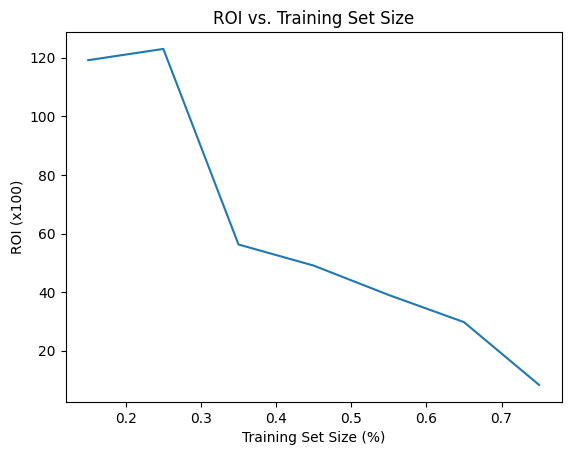

In [134]:
import matplotlib.pyplot as plt
#Create ROI graph for each iteration above
ROIs = [x/100 for x in ROIs] #Divide by 100 to better reflect how its shown in the paper
plt.plot(train_percentages, ROIs)
plt.title("ROI vs. Training Set Size")
plt.xlabel("Training Set Size (%)")
plt.ylabel("ROI (x100)")
plt.show()

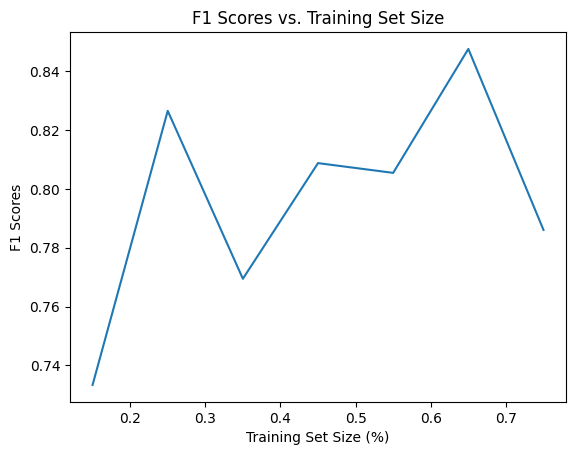

In [135]:
#Create f1 score for each iteration above
plt.plot(train_percentages, f1_scores1)
plt.title("F1 Scores vs. Training Set Size")
plt.xlabel("Training Set Size (%)")
plt.ylabel("F1 Scores")
plt.show()